In [1]:
# Necessary libraries
import os
import sys
import csv
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [2]:
# Data directory
accident_csv = os.path.join("FARS2015NationalCSV", "accident.csv")
print(accident_csv)

# Set print limits to show all columns
pd.set_option('display.max_columns', 500)  

# Convert to dataFrame
accident_df = pd.read_csv(accident_csv)
accident_df.head()

FARS2015NationalCSV\accident.csv


,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,RUR_URB,FUNC_SYS,RD_OWNER,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,1,1,0,0,0,1,1,127,0,1,1,2015,5,2,40,0,1,3,1,3,SR-5,NaN,1754,34,-87,0,35,0,0,1,1,0,4,2,1,0,1,0,0000000,99,99,2,58,88,88,0,0,0,1,1
1,1,10002,1,1,0,0,0,1,1,83,0,1,1,2015,5,22,13,1,1,1,1,1,I-65,NaN,3604,35,-87,0,34,0,0,1,1,0,3,2,10,0,10,0,0000000,99,99,22,20,88,88,0,0,0,1,0
2,1,10003,1,1,0,0,0,2,2,11,0,1,1,2015,5,1,25,0,1,3,1,2,US-SR 6,NaN,1958,32,-86,0,42,0,0,1,1,0,4,2,1,0,1,0,0000000,99,99,1,45,99,99,0,0,0,1,1
3,1,10004,1,1,0,0,0,1,1,45,0,4,1,2015,1,0,57,0,1,4,1,3,SR-27,NaN,566,31,-86,0,53,0,0,1,1,0,4,2,10,0,10,0,0000000,99,99,1,15,88,88,0,0,0,1,1
4,1,10005,2,2,0,0,0,2,2,45,2050,7,1,2015,4,7,9,0,2,3,1,2,US-SR 53,HINTON WATERS AVE,308,31,-86,0,12,6,0,2,3,0,1,1,1,0,1,0,0000000,99,99,7,16,88,88,0,0,0,1,0


In [3]:
# Keep relevant columns
accident_df = accident_df[["STATE", "ST_CASE", "COUNTY", "CITY", "DAY", "MONTH", "YEAR", "DAY_WEEK", "HOUR", "MINUTE", "WEATHER", "DRUNK_DR"]]

accident_df.head()

,STATE,ST_CASE,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,WEATHER,DRUNK_DR
0,1,10001,127,0,1,1,2015,5,2,40,1,1
1,1,10002,83,0,1,1,2015,5,22,13,10,0
2,1,10003,11,0,1,1,2015,5,1,25,1,1
3,1,10004,45,0,4,1,2015,1,0,57,10,1
4,1,10005,45,2050,7,1,2015,4,7,9,1,0


In [4]:
accident_df.mean()  # just to check if there's NaN present

STATE           27.604769
ST_CASE     276729.623733
COUNTY          91.225051
CITY          1197.810918
DAY             15.556208
MONTH            6.790680
YEAR          2015.000000
DAY_WEEK         4.101598
HOUR            13.465056
MINUTE          28.954766
WEATHER          3.808711
DRUNK_DR         0.283094
dtype: float64

In [5]:
# Clean up data using PDF to translate
# County / City number can be obtained by GSA geographical codes (usually)
#print(accident_df.dtypes)
stateDict = {1 : "Alabama", 2 : "Alaska", 4 : "Arizona", 5 : "Arkansas", 6 : "California", 8 : "Colorado", 9 : "Connecticut", 
            10 : "Delaware", 11 : "District of Colombia", 12 : "Florida", 13 : "Georgia", 15 : "Hawaii", 16 : "Idaho", 
            17 : "Illinois", 18 : "Indiana", 19 : "Iowa", 20 : "Kansas", 21 : "Kentucky", 22 : "Louisiana", 23 : "Maine", 
            24 : "Maryland", 25 : "Massachusetts", 26 : "Michigan", 27 : "Minnesota", 28 : "Mississippi", 29 : "Missouri", 
            30 : "Montana", 31 : "Nebraska", 32 : "Nevada", 33 : "New Hampshire", 34 : "New Jersey", 35 : "New Mexico", 
            36 : "New York", 37 : "North Carolina", 38 : "North Dakota", 39 : "Ohio", 40 : "Oklahoma", 41 : "Oregon", 
            42 : "Pennsylvania", 43 : "Puerto Rico", 44 : "Rhode Island", 45 : "South Carolina", 46 : "South Dakota", 
            47 : "Tennessee", 48 : "Texas", 49 : "Utah", 50 : "Vermont", 52 : "Virgin Islands", 51 : "Virginia", 
            53 : "Washington", 54 : "West Virginia", 55 : "Wisconsin", 56 : "Wyoming"}
dayweekDict = {1 : "Sunday", 2 : "Monday", 3 : "Tuesday", 4 : "Wednesday", 5 : "Thursday", 6 : "Friday", 7 : "Saturday"}
weatherDict = {1 : "Clear", 0 : "No Additional Conditions", 2 : "Rain", 3 : "Sleet/Hail", 4 : "Snow", 5 : "Fog/Smog/Smoke", 
              6 : "Severe Crosswinds", 7 : "Blowing Sand/Soil/Dirt", 8 : "Other", 10 : "Cloudy", 11 : "Blowing Snow", 
              12 : "Freezing Rain/Drizzle", 98 : "Not Reported", 99 : "Unknown"}

accident_df["STATE"].replace(stateDict, inplace = True)
accident_df["DAY_WEEK"].replace(dayweekDict, inplace = True)
accident_df["WEATHER"].replace(weatherDict, inplace = True)
accident_df
#accident_df["WEATHER"].value_counts()
# Several that can likely be merged, 355 unknown/unreported, 59 other
# Can alter the dictionary or merge them directly if we choose to

,STATE,ST_CASE,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,WEATHER,DRUNK_DR
0,Alabama,10001,127,0,1,1,2015,Thursday,2,40,Clear,1
1,Alabama,10002,83,0,1,1,2015,Thursday,22,13,Cloudy,0
2,Alabama,10003,11,0,1,1,2015,Thursday,1,25,Clear,1
3,Alabama,10004,45,0,4,1,2015,Sunday,0,57,Cloudy,1
4,Alabama,10005,45,2050,7,1,2015,Wednesday,7,9,Clear,0
5,Alabama,10006,111,0,8,1,2015,Thursday,9,59,Clear,0
6,Alabama,10007,89,1730,8,1,2015,Thursday,18,33,Clear,0
7,Alabama,10008,73,350,3,1,2015,Saturday,21,30,Rain,0
8,Alabama,10009,117,47,13,1,2015,Tuesday,8,0,Cloudy,0
9,Alabama,10010,33,0,5,1,2015,Monday,18,45,Clear,0


In [ ]:
# export table to csv so we don't need to run the whole notebook to look at

In [17]:
# Time for question 0 (just got this idea last-minute, might not use):
# Number of accidents vs. day
accident_df = accident_df.sort_values(["MONTH", "DAY"])


accident_by_day = pd.DataFrame()
# Create groupby object to rank by accident by the day
accident_gby_day = accident_df[["MONTH", "DAY", "DAY_WEEK", "STATE"]].groupby(["MONTH", "DAY", "DAY_WEEK"])
accident_by_day = accident_gby_day.count()
accident_by_day = accident_by_day.rename(columns = {"STATE": "Accidents"})
accident_by_day = accident_by_day.reset_index(drop=False, inplace=False)
accident_by_day["Day of year"] = accident_by_day.index.copy() + 1

# Pretty-display all rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(accident_by_day)

,MONTH,DAY,DAY_WEEK,Accidents,Day of year
0,1,1,Thursday,105,1
1,1,2,Friday,65,2
2,1,3,Saturday,95,3
3,1,4,Sunday,52,4
4,1,5,Monday,79,5
5,1,6,Tuesday,78,6
6,1,7,Wednesday,56,7
7,1,8,Thursday,60,8
8,1,9,Friday,106,9
9,1,10,Saturday,76,10


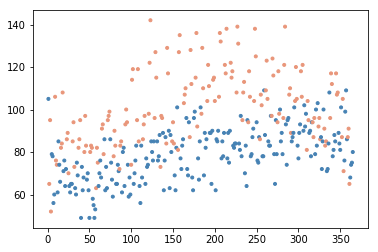

In [65]:
# Plot instances of accidents vs day of year

x = accident_by_day["Day of year"]
y = accident_by_day["Accidents"]

color = ["steelblue"if item in ["Monday", "Tuesday", "Wednesday", "Thursday"] else "darksalmon"  for item in accident_by_day["DAY_WEEK"] ]

plt.scatter(x, y, marker=".", alpha=1, c=color)

plt.show()

In [ ]:
# Plot specifically # accidents by day of the week 